## Regularization

#### Neural network memorize - Overfit

One of the striking aspects about fully connected networks is that they tend to memorize the training data given enough time. As a result, traininga FCN to convergence isn't really a meaningful metric. 
For large enough networks, it is quite common for training loss to trend all the way to zero. This empirical observation is one of the most pratical demonstrations of the universal approximation capabilities of FCN. 
Note that training loss trending to zero does not mean that the network has learned a more powerful model It is rather likely that the model has started to memorize peculiarities of the training set that are not applicable to any other datapoints.

Controlling networks and preventing them from misbehaving in this fashion is critical for modeling success.

Regularization is the general statistical term for a mathematical operation that limits memorization while promoting a generalizable learning. There are many different types of regularization available.

## Dropout

Dropout is a form of regularization that randomly drops some proportion of the nodes that feed into a fully connected layer. That means that the contribution of the dropped node to the corresponding activation function is set to 0. In this way the gradients for dropped nodes drop to zero as well. 
The nodes to be dropped are chosen at random during each step of gradient descent. The principle is that the network will be forced to avoid co-adaption. Briefly: suppose that one neuron in a deep network has learned a useful representation, then other deeper neurons will rapidly learn to depend on that particular neuron for information. This process will render the network brittle since the network will depend ecxcessively on the features learned by that neurons, which might represent a small part of the dataset, insted of learning a general rule.
Dropout prevents this type of co-adaption because it will no longer be possible to depend on the presence of single powerful neurons, in this way the other neurons will be forced to learn useful representations as well.

Dropout prevents the network from memorizing the training dta, the loss will no longer tend rapidly toward 0. And then they tends to slightly boost the predictive power of the model on new data.

#### REMEMBER TO TURN OFF THE DROPOUT WHEN MAKING PREDICTIONS!

#### Adding dropout to a hidden layer

TF takes care of implementing dropout in the built-in <code> tf.nn.dropout(x,keep_prob) </code> where <i>keep_prob</i> is the probability that any given node is kept. We need a new placeholders.

In [65]:
n_hidden = [70,70,70,70,70]
n_lay = len(n_hidden)

tf.reset_default_graph() #In order to permit us to instantiate new variables
    #d = len(X_train)


with tf.name_scope("placeholders"):

    x = tf.placeholder(tf.float32, (None,2))

    y = tf.placeholder(tf.float32, (None,))

    keep_prob = tf.placeholder(tf.float32) #Keep prob!

with tf.name_scope("hidden-layer"):


    
    for lay in range(0,n_lay):
        
        if(lay == 0):
            
            W = tf.Variable(tf.random_normal((2,n_hidden[0])))

            b = tf.Variable(tf.random_normal((n_hidden[0],)))

            out_hidd = tf.nn.relu(tf.matmul(x,W) + b) #(600)
            
            out_hidd = tf.nn.dropout(out_hidd, keep_prob)
        
        else:

            W = tf.Variable(tf.random_normal((n_hidden[lay-1],n_hidden[lay])))

            b = tf.Variable(tf.random_normal((n_hidden[lay],)))




            out_hidd = tf.nn.relu(tf.matmul(out_hidd,W) + b)
            #out_hidd = tf.nn.dropout(out_hidd, keep_prob)
        


with tf.name_scope("output"):

    W = tf.Variable(tf.random_normal((n_hidden[-1],1)))

    b = tf.Variable(tf.random_normal((1,)))

    y_logit = tf.matmul(out_hidd,W)+b

    y_one_prob = tf.sigmoid(y_logit)

    y_pred = tf.round(y_one_prob)

with tf.name_scope("loss"):

    y_expand = tf.expand_dims(y,1)

    entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = y_logit, labels = y_expand)

    l = tf.reduce_sum(entropy)

with tf.name_scope("optim"):

    train_op = tf.train.AdamOptimizer(0.001).minimize(l)

with tf.name_scope("summaries"):

    tf.summary.scalar("loss",l)

    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./Output/nn-train', tf.get_default_graph())






W0828 19:39:26.837498 140242084759360 deprecation.py:506] From <ipython-input-65-f4fae98120bb>:30: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [66]:
from tqdm import tqdm_notebook

    
import imageio
images = []


loss_train = []
loss_test = []

acc_train = []
acc_test = [] 

n_steps = 500

pbar = tqdm_notebook(range(n_steps), desc = "Epochs")


with tf.Session() as fcnn:
    
    fcnn.run(tf.global_variables_initializer())
    
    for i in range(0,n_steps):          

        dicti_train = {x: X_train, y:Y_train, keep_prob : 0.9} #Train dict

        _,summary,loss = fcnn.run([train_op,merged,l], feed_dict = dicti_train) #Running the train
        
        dicti_test = {x: X_test, y: Y_test, keep_prob : 1} #Test dict
        summary_t, loss_t = fcnn.run([merged,l], feed_dict=dicti_test) #Running the test     
        
        #Loss functions
        loss_train.append(loss)
        loss_test.append(loss_t)
        train_writer.add_summary(summary,i)       
        
        #Making predictions    
        y_pred_train = fcnn.run(y_pred, feed_dict={x: X_train, keep_prob : 0.9})
        score_train = accuracy_score(Y_train, y_pred_train) #Computing the accuracy   

        pbar.update()


        #if(i % 10 == 0): #One can decide not to test every epoch but after a few ones. (Rembember to indent)
        
        #Making predictions on the test dataset in order to compute the accuracy every step.
        y_pred_test = fcnn.run(y_pred, feed_dict={x: X_test, keep_prob : 1}) 
        score_test = accuracy_score(Y_test, y_pred_test) #Computing the accuracy on the test dataset

        acc_train.append(score_train) 
        acc_test.append(score_test)

    w_final, b_final = fcnn.run([W, b]) #Saving the final results
    
    # Make Predictions on test
    y_pred_test = fcnn.run(y_pred, feed_dict={x: X_test, keep_prob: 1}) #Final predictions
    
    y_proba = fcnn.run(y_one_prob, feed_dict = {x:X_test, keep_prob: 1}) #Final predictions (probability)
    

    
    score = accuracy_score(Y_test, y_pred_test)
    print("Classification Accuracy: %f" % score)
fcnn.close() #Closing the session.



Classification Accuracy: 0.998667


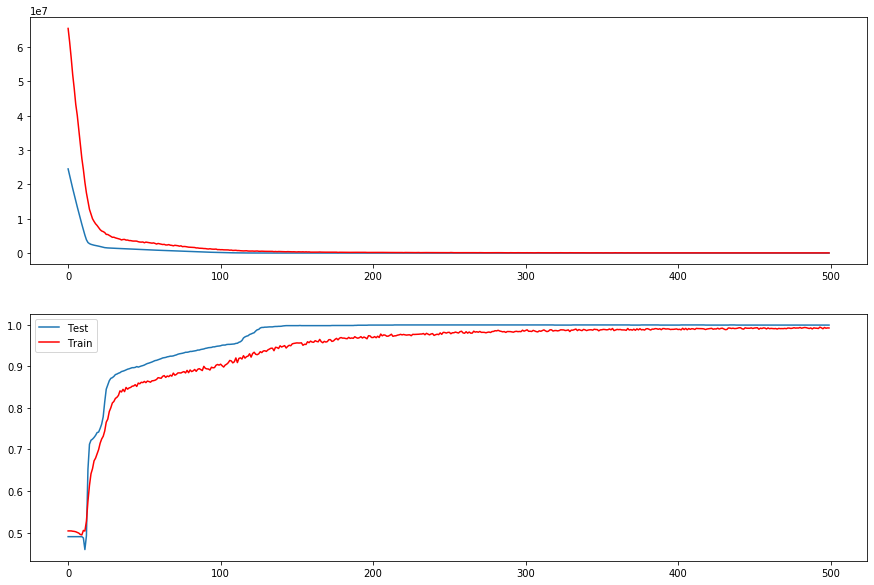

In [67]:
fig = plt.figure(figsize = (15,10))

plt.subplot(211)

plt.plot(loss_test, label = 'Test')
plt.plot(loss_train, color = 'red', label = 'Train' )

plt.subplot(212)

plt.plot(acc_test, label = 'Test')
plt.plot(acc_train, color = 'red', label = 'Train')

plt.legend()
plt.show()

In [68]:
#!tensorboard --logdir=./Output/nn-train

<a id='Keras'></a>
# KERAS 

Tensorflow and PyThorch permit to develop customised models following step by step the train chain. For a more simple use one can use keras, that has a more simple sintax. Keras is also very customizable and permit to add regularization in a very fast way. Let's see how to use Keras on a physical problem. 
This problem is a classification problem. We have two different dataset, one for the signal process and one for the background process. The purpose of the analysis is to train a model for the discrimination of signal and background events. 

In [69]:
import pandas as pd
import seaborn as sns #useful for statistical data visualization
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.special import logit
from sklearn.preprocessing import StandardScaler

signal_file = './Data/Signal.npy' #Signal dataset
bkg_file = './Data/Background.npy' #Background dataset
s_header_file = './Data/Signal_var.npy' #Signal variables names
b_header_file = './Data/Background_var.npy' #Background variables names.

#Simple function that returns the features dataset and the target one (label = signal, background (1,0))
def to_xy(df,target):
    y = df[:,target]
    x = np.delete(df, target, 1)
    return x,y


In [70]:
S = np.load(signal_file)
B = np.load(bkg_file)
S_header = np.load(s_header_file)[0,:-1]
B_header = np.load(b_header_file)[0,:-1]
dataset = np.vstack([S,B])
np.random.shuffle(dataset)
train,target = to_xy(dataset,dataset.shape[1]-1)

## Some plots

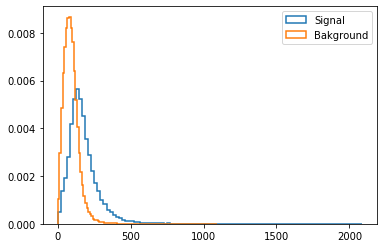

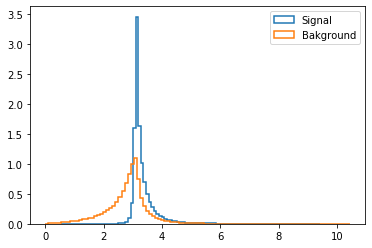

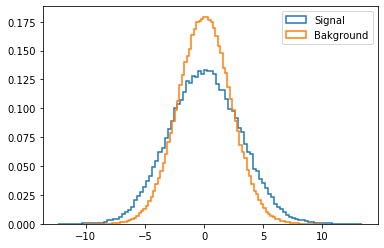

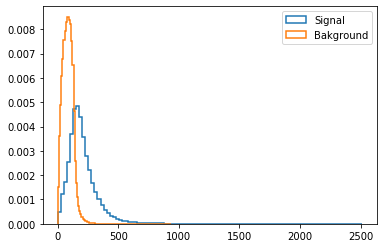

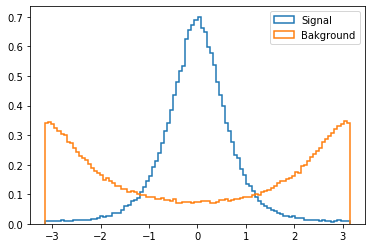

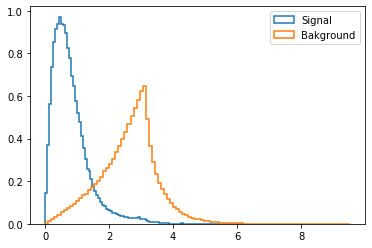

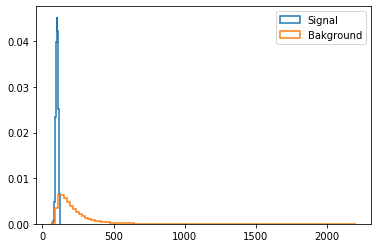

In [71]:
for i in range(0,7):
    plt.hist(S[:,i],bins = 100, density = True,histtype = 'step', fill = False,linewidth = 1.5,label = 'Signal')
   # plt.hist(my_data[:,feature_index], 50, density=True, histtype='step', fill=False, linewidth=1.5)
    plt.hist(B[:,i],bins = 100, density = True,histtype = 'step', fill = False,linewidth = 1.5,label = 'Bakground')
    plt.legend()
    plt.show()

# Correlation matrix

Seaborn permits to visualize the heatmap of a matrix exploiting the method <code>sns.heatmap()</code>. We will compute the correlation matrix through the pandas library.

### Signal

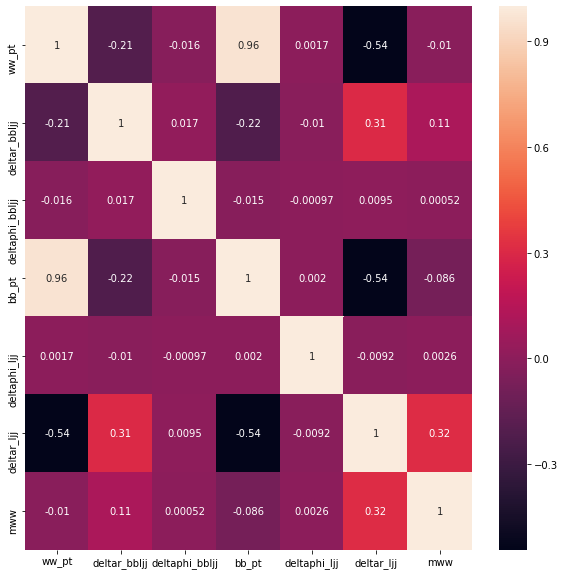

In [72]:
fig = plt.figure(figsize = (10,10))
sns.heatmap(pd.DataFrame(S[:,0:-1],columns = S_header).corr(), annot = True)

### Background

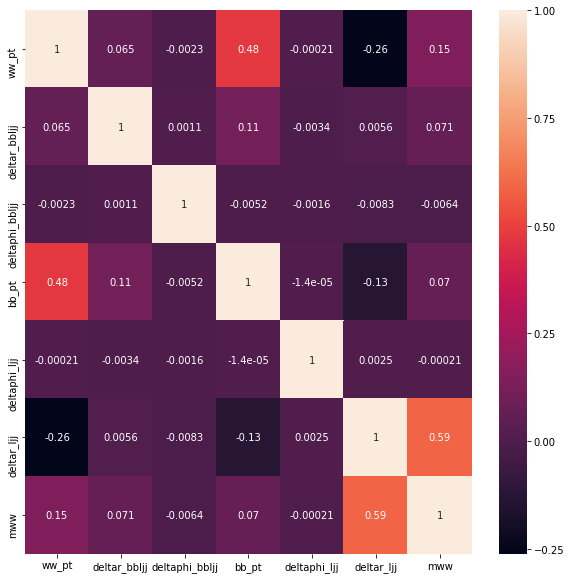

In [73]:
fig = plt.figure(figsize = (10,10))
sns.heatmap(pd.DataFrame(B[:,0:-1],columns = B_header).corr(), annot = True)

### Split the dataset in train and validation

The best thing to do is to create three different dataset. The train one, the validation one and the test one. The validation dataset is need for the correct tuning of the hyperparameters, while the test one is for the last step, the prediction. Indeed,  the test dataset is a dataset used to provide an unbiased evaluation of a final model fit on the training dataset. If the data in the test dataset has never been used in training (for example in cross-validation), the test dataset is also called a holdout dataset. 
Sklearn doesn't provide a method for the split in three different dataset, but we can write a small function for this purpose.

In [74]:
import sklearn

def data_split(examples, labels, train_frac, random_state=None):
    ''' https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    param data:       Data to be split
    param train_frac: Ratio of train set to whole dataset

    Randomly split dataset, based on these ratios:
        'train': train_frac
        'valid': (1-train_frac) / 2
        'test':  (1-train_frac) / 2

    Eg: passing train_frac=0.8 gives a 80% / 10% / 10% split
    '''

    assert train_frac >= 0 and train_frac <= 1, "Invalid training set fraction"

    X_train, X_tmp, Y_train, Y_tmp = sklearn.model_selection.train_test_split(
                                        examples, labels, train_size=train_frac, random_state=random_state)

    X_val, X_test, Y_val, Y_test   = sklearn.model_selection.train_test_split(
                                        X_tmp, Y_tmp, train_size=0.5, random_state=random_state)

    return X_train, X_val, X_test,  Y_train, Y_val, Y_test

In [75]:
x_train, x_val, x_test, y_train, y_val, y_test = data_split(train, target, 0.6)

### Preprocessing

Let's start with the standardization of the train dataset

In [76]:
scaler = StandardScaler(copy = False, with_mean = True, with_std = True)
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


In [77]:
# keras imports
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, Flatten
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [78]:
input_shape = x_train.shape[1]
dropoutRate = 0.1
print("Input_shape: ",(input_shape))



Input_shape:  7


In [79]:
#### Using the API ####
inputArray = Input(shape=(input_shape,))
#
x = Dense(100, activation='relu')(inputArray) #Input layer
x = Dropout(dropoutRate)(x)
#
x = Dense(100, activation='relu')(x) #1st hidden layer
x = Dropout(dropoutRate)(x)
#
x = Dense(100, activation='relu')(x)# 2nd hidden layer
x = Dropout(dropoutRate)(x)
#
x = Dense(100, activation='relu')(x)#3rd hidden layer
#
output = Dense(1, activation='sigmoid')(x) #output layer, Note: binary-classification -> 1 output neuron, sigmoid.
####
model = Model(inputs=inputArray, outputs=output) #Creating the model

W0828 19:40:09.426687 140242084759360 deprecation_wrapper.py:119] From /home/wahid/Programs/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 19:40:09.427734 140242084759360 deprecation_wrapper.py:119] From /home/wahid/Programs/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 19:40:09.568724 140242084759360 deprecation_wrapper.py:119] From /home/wahid/Programs/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 19:40:09.596990 140242084759360 deprecation_wrapper.py:119] From /home/wahid/Programs/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. P

In [80]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])#Compiling the model.
model.summary()

W0828 19:40:09.773332 140242084759360 deprecation_wrapper.py:119] From /home/wahid/Programs/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 19:40:09.807998 140242084759360 deprecation_wrapper.py:119] From /home/wahid/Programs/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________

In [81]:
batch_size = 128
n_epochs = 50

We can set some regularization. In this case we will use the <code>EarlyStopping</code> which stops the training when the validation loss function doesn't decrease within a threshold fixed by the user for a fixed number of epochs (patience). The <code>EarlyStopping</code> is important in order to avoid the overtraining. 
A second type of Regularization is the <code>ReduceLROnPlateu</code> and works as follow: when the validation loss stop decreasing within a threshold the model try to improve the level of training reducing the learning rate. The purpose of that is to get as close as possible to the real minima in order to tune the hyperparameters properly.
Then we have the last callback, <code>TerminateOnNaN()</code> that terminates the training when a NaN loss is encountered.

In [82]:
# train 
#tf.reset_default_graph()
with tf.Session() as ker: #Session only because there are different graphs instantiate before.
                      #If they don't exist you don't have to start a new session.
    
    
    history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 1,
                    validation_data=(x_val, y_val),
                    callbacks = [
                    EarlyStopping(monitor='val_loss', patience=10, verbose=1), #Early stopping on validation loss
                    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                    TerminateOnNaN()]) #Reduce learning rate when the metric has stop improving

    pred = model.predict(x_test) #the inference step, note: the test dataset is passed.
 


Train on 182449 samples, validate on 60816 samples
Epoch 1/50
182449/182449 [==============================] - 7s 40us/step - loss: 0.0705 - acc: 0.9724 - val_loss: 0.0400 - val_acc: 0.9852
Epoch 2/50
182449/182449 [==============================] - 6s 34us/step - loss: 0.0408 - acc: 0.9848 - val_loss: 0.0371 - val_acc: 0.9865
Epoch 3/50
182449/182449 [==============================] - 6s 34us/step - loss: 0.0365 - acc: 0.9865 - val_loss: 0.0334 - val_acc: 0.9881
Epoch 4/50
182449/182449 [==============================] - 6s 35us/step - loss: 0.0352 - acc: 0.9873 - val_loss: 0.0328 - val_acc: 0.9884
Epoch 5/50
182449/182449 [==============================] - 7s 37us/step - loss: 0.0343 - acc: 0.9878 - val_loss: 0.0333 - val_acc: 0.9882
Epoch 6/50
182449/182449 [==============================] - 7s 38us/step - loss: 0.0334 - acc: 0.9881 - val_loss: 0.0342 - val_acc: 0.9877

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/50
182449/182449 [=======

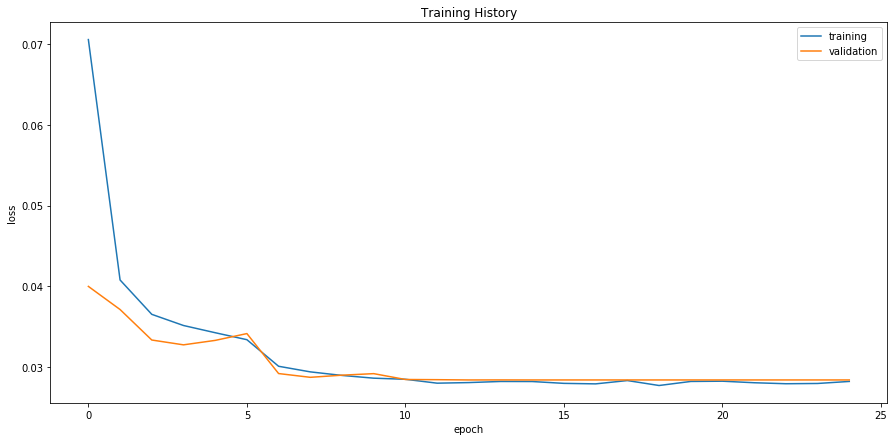

In [83]:
# plot training history
fig = plt.figure(figsize = (15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

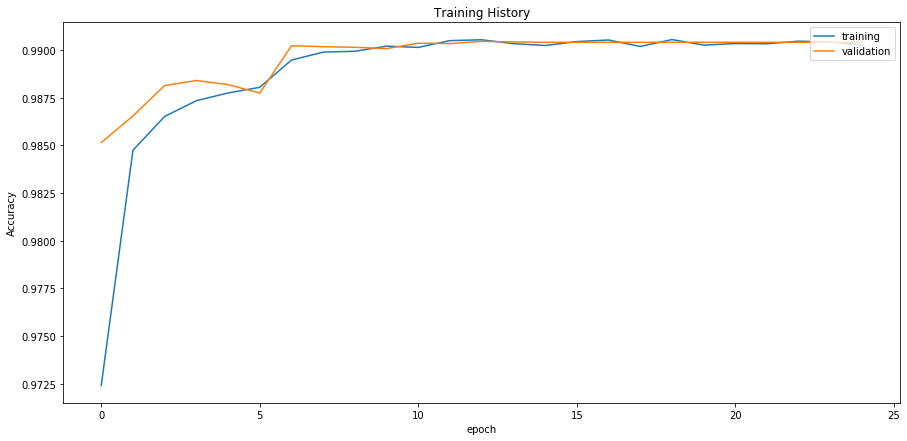

In [84]:
# plot training history
fig = plt.figure(figsize = (15,7))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
#plt.yscale('log')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Normalized confusion matrix
[[0.9888024  0.0111976 ]
 [0.00159962 0.99840038]]


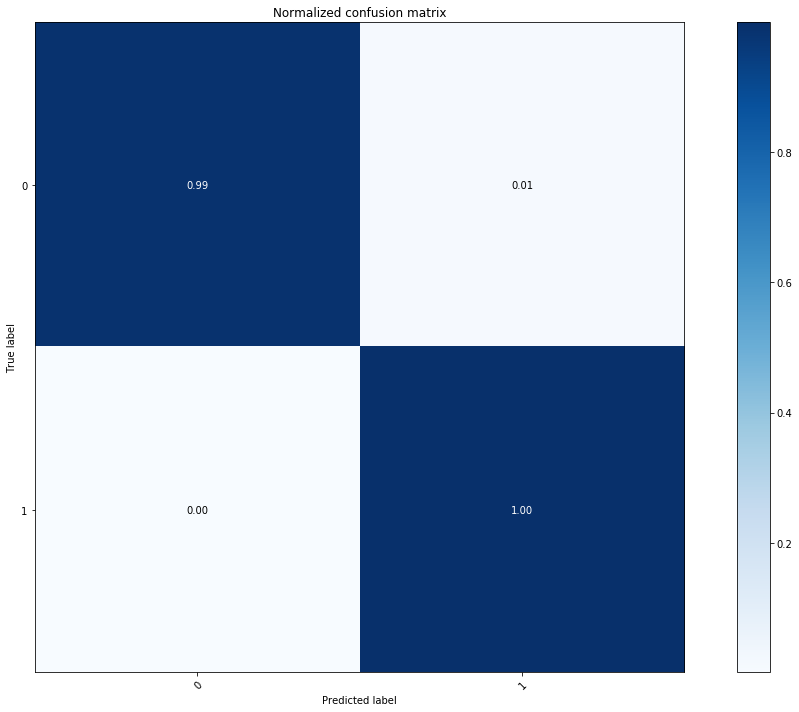

In [85]:
y_pred = pred.reshape(-1)
y_pred = np.around(y_pred,0)
plot_confusion_matrix(y_test,y_pred,classes = [0,1],normalize=True) #NOTE: using the test dataset!

In [86]:
response_S = []
response_B = []



for i in range(len(pred)):
    if(y_test[i] == 1):
        response_S.append(pred[i][0])
    else:
        response_B.append(pred[i][0])
        

A very important plot when studying a binary classification problem is the response of the network.

In [ ]:
fig = plt.figure( figsize = (15,8))
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
plt.hist(response_S,bins = 100, label = 'Signal', alpha = 0.5)
plt.hist(response_B,bins = 100, label = 'Background', alpha = 0.5)
plt.title("Network response")
plt.xlabel("Network response")
plt.ylabel("Counts")
plt.legend()
plt.show()

## ROC Curve

AUC (area under the curve) - ROC (Receiver operating characteristic) curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.

The ROC curve is plotted with TPR (true positive rate) against the FPR (false positive rate) where TPR is on y-axis and FPR is on the x-axis.

$$TPR = \frac{TP}{TP + FN}$$


$$FPR =\frac{FP}{TN + FP} $$

A simple explanation of the ROC curve and its interpretation can be found here: <a href="https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5/"> ROC-AUC </a>

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test,pred)
score = roc_auc_score(y_test,pred)

In [ ]:
plt.figure(figsize = (10,10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Grid search

The choice of the model parameter can be very important. In order to try different combinations of parameters in a simple way, scikit learn provides the GridSearchCV methods. Note: computationally speaking is very expansive! It can take a lot of hours!

In [ ]:
import multiprocessing
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#Defining a function that returns a built model. The sintax adopted is a little bit different -> is just for example.
def create_model(n_layer ,neurons, activation, optimizer = "adam"):
    
    model = Sequential()
    
    model.add(Dense(neurons, input_dim = input_shape, activation = activation))
    
    for i in range(0,n_layer):         
        
         model.add(Dense(neurons, activation = activation))            
        
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics=['acc'])

    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = KerasClassifier(build_fn = create_model, verbose = 1)


early_stop = EarlyStopping(monitor = "val_loss" ,min_delta=1e-8, patience=3, verbose=1, mode='auto')

#The following ranges are small! Is just for example!

epochs = [i for i in range(100,140,20)]
neurons = [i for i in range(3,4)]
n_layers = [i for i in range(1,2)]


#The gridsearch method needs a dictionary!
#The activatin functions and the optimizers available can be found on the keras website!
activation = ["relu","tanh"] 
optimizer = ["adam"]
param_grid = {'epochs': epochs,
              'n_layer':n_layers,
              'neurons':neurons,
              'activation':activation,
               'optimizer': optimizer}

#n_jobs stands for the number of cores that will be used, cv stands for cross-validation!
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = 4, verbose = 1, cv = 2)

In [ ]:
with tf.Session() as ker2:
    grid_result = grid.fit(x_train,y_train, verbose = 1,validation_data=(x_val,y_val), callbacks = [
                    early_stop, #Early stopping on validation loss
                    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                    TerminateOnNaN()] )

Note: if the notebook was opened from a shell, sometimes the output of the training is printed in the shell instead of in the notebook

Let's have a look on the best parameters found by the grid search

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
ep_best = grid_result.best_params_["epochs"]
nrn_best = grid_result.best_params_["neurons"]
activ = grid_result.best_params_["activation"]
lay = grid_result.best_params_["n_layer"]
optim = grid_result.best_params_["optimizer"]

model = create_model(lay,nrn_best,activ)

model.compile(loss = 'binary_crossentropy', optimizer = optim, metrics=['acc'])

with tf.Session() as ker_fin:
    history_cv = model.fit(x_train, y_train, epochs=ep_best, validation_data=(x_val, y_val))

#And then as before...